In [60]:
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
EXP_BASE_DIR = "/home/darshan/work/course/dissertation/"
exp_1_file = EXP_BASE_DIR + "idiom_principle_on_magpie_corpus/experiments/exp3B_1/checkpoints_SeqClassifier/test_results_None.txt"
exp_2_file = EXP_BASE_DIR + "bertram_on_magpie/experiments/bt2//checkpoints_SeqClassifier/test_results_None.txt"

exp_1_NAME = "exp3B_1"
exp_2_NAME = "bt2"

In [62]:
id_to_label = {0: 'i', 1: 'l'}
PROBABILITY_COL = "prediction_prob"

In [63]:
# Should contain tab separated 'index \t prediction \t prediction_prob' columns
exp_1_df = pd.read_csv(exp_1_file, sep='\t')
exp_2_df = pd.read_csv(exp_2_file, sep='\t')

In [64]:
# # Concatenate the two dataframes side-by-side
# all_cols = exp_1_df.columns
# exp1_renames = {col: f"{exp_1_NAME}_{col}" for col in all_cols}
# exp2_renames = {col: f"{exp_2_NAME}_{col}" for col in all_cols}
# exps_combined_df = pd.concat([exp_1_df.rename(columns=exp1_renames), exp_2_df.rename(columns=exp2_renames)], axis=1)
# exps_combined_df

Text(0.5, 1.0, 'Distribution of prediction probabilities')

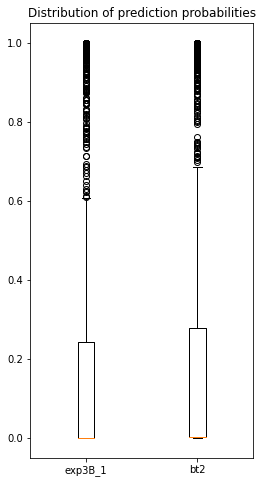

In [65]:
# Distributions of probabilities
fig, ax = plt.subplots(figsize=(4,8))
ax.boxplot([exp_1_df[PROBABILITY_COL], exp_2_df[PROBABILITY_COL]])
ax.set_xticklabels([exp_1_NAME, exp_2_NAME])
ax.set_title("Distribution of prediction probabilities")

In [66]:
exp_1_df[[PROBABILITY_COL]].describe()

,prediction_prob
count,4840.000000
mean,0.239743
std,0.413564
min,0.000100
25%,0.000400
50%,0.001100
75%,0.243150
max,0.999700


In [67]:
exp_2_df[[PROBABILITY_COL]].describe()

,prediction_prob
count,4840.000000
mean,0.245678
std,0.415775
min,0.000500
25%,0.001900
50%,0.003800
75%,0.277325
max,0.999200


In [68]:
# Check if the probabilities follow a normal distribution or not
# Use 'Shapiro-Wilk test' for normality test
W_test_value, p_value = stats.shapiro(exp_1_df[PROBABILITY_COL])
print(f"{exp_1_NAME} probabilities normality test: W={W_test_value}, p-value={p_value}")

W_test_value, p_value = stats.shapiro(exp_2_df[PROBABILITY_COL])
print(f"{exp_2_NAME} probabilities normality test: W={W_test_value}, p-value={p_value}")

exp3B_1 probabilities normality test: W=0.5601496696472168, p-value=0.0
bt2 probabilities normality test: W=0.564132571220398, p-value=0.0


In [69]:
# Since both the p-values are significant (<0.5), both the distributions violate the assumption of normality. 
# Therefore, the Wilcoxon signed rank test, a.k.a the Wilcoxon T test, is the correct test to use to analyze this data.
# Ref https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/

In [70]:
# Statistical significance test
def statistical_significance_test(sequence_1, sequence_2):
    """
    Perform statistical significance test (wilcoxon-sign-ranked-test) on the two sequences.
    Print the results of the test.
    """
    # Ref https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/
    return stats.wilcoxon(sequence_1, sequence_2, zero_method='zsplit', correction=True)

In [71]:
statistical_significance_test(exp_1_df[PROBABILITY_COL], exp_2_df[PROBABILITY_COL])

WilcoxonResult(statistic=3878590.0, pvalue=4.0497424917060814e-92)

## Interpretation of the results
The results are statistically significant! We can reject the null hypothesis in support of the alternative.

A **Wilcoxon T test** was used to analyze the prediction probabilities of *exp_1* and *exp_2* to test if the two models have predicted similarly or differently.

The p-value is lower the significance level of 0.01, hence we have statistically significant evidences to reject the null hypothesis(that the two data are similar) and to accept that the two data are different.
**Clearly, there is a statistically significant difference in the prediction probabilities between the two experiments. Hence, the observed differences in the model performance are not just by chance.**